<a href="https://colab.research.google.com/github/AlbertFlorinus/mnistcnn/blob/preprocessing_notes/digitsview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from keras.preprocessing import image
from scipy.ndimage import rotate
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import os
from cv2 import cv2
import math
from scipy import ndimage

import sys

from PIL import Image

In [ ]:
!cd /digits

In [ ]:
!unzip /content/drive/MyDrive/digits2.zip -d /content/digits

In [79]:
def getBestShift(img):
  cy,cx = ndimage.measurements.center_of_mass(img)
  
  rows,cols = img.shape
  shiftx = np.round(cols/2.0-cx).astype(int)
  shifty = np.round(rows/2.0-cy).astype(int)
  return shiftx,shifty

In [80]:
def shift(img, sx, sy):
  # preprocessing
  rows,cols = img.shape
  M = np.float32([[1,0,sx],[0,1,sy]])
  shifted = cv2.warpAffine(img,M,(cols,rows))
  return shifted

In [81]:
def image_manip(subj, prc = True):
  # this method uses the methods "shift" and "getBestShift" to preprocess the image.

  # this code (50-62) removes the rows and columns at the edge of the image,
  # which are completely black as a result of previous thresholding.
  # this resize the image to 71% rounded up of the previous size,
  # so that a size of 112x112 now becomes 80x80, with the edges not containing information,
  # of the digits now removed.
  while np.sum(subj[0]) == 0:
      subj = subj[1:]

  while np.sum(subj[:,0]) == 0:
      subj = np.delete(subj,0,1)

  while np.sum(subj[-1]) == 0:
      subj = subj[:-1]

  while np.sum(subj[:,-1]) == 0:
      subj = np.delete(subj,-1,1)

  rows,cols = subj.shape

  # this resize the
  if rows > cols:
      factor = 80.0/rows
      rows = 80
      cols = int(round(cols*factor))
      subj = cv2.resize(subj, (cols,rows))
  else:
      factor = 80.0/cols
      cols = 80
      rows = int(round(rows*factor))
      subj = cv2.resize(subj, (cols, rows))

  # get padding
  colsPadding = (int(math.ceil((112-cols)/2.0)),int(math.floor((112-cols)/2.0)))
  rowsPadding = (int(math.ceil((112-rows)/2.0)),int(math.floor((112-rows)/2.0)))

  # apply padding
  subj = np.lib.pad(subj,(rowsPadding,colsPadding),'constant')
  
  # some preprocessing
  if prc == True:
    shiftx,shifty = getBestShift(subj)
    shifted = shift(subj,shiftx,shifty)
    subj_done = shifted
  else:
    subj_done = subj
  return subj_done

In [ ]:
#This is the original image 
#plt.imshow(gray_orig, cmap="gray")

In [82]:
def boilerplate(img, img2):
  # converting PIL image to numpy array
  img = image.img_to_array(img)
  img2 = image.img_to_array(img2)
  #original = image.img_to_array(gray)

  # reshaping to 1 channel (its only 1 image), 112x112 shape, and 1 color channel (grayscale)
  test_img = img.reshape((1,112,112,1))
  test_img2 = img2.reshape((1,112,112,1))
  #original = original.reshape((1,112,112,1))

  # change datatype from uint8 to float32
  test_img = img.astype('float32')
  test_img2 = img2.astype('float32')
  #original = original.astype('float32')

  # normalizing pixels in the decimal range 0 to 1
  test_img /= 255
  test_img2 /= 255
  #original /= 255

  # extend axis at index[0] to ready for prediction
  # These are inputs to the neural net
  test_img = np.expand_dims(test_img, axis=0)
  test_img2 = np.expand_dims(test_img2, axis=0)
  #original = np.expand_dims(original, axis=0)

  # reshaping again for showing image to user
  test_img = test_img.reshape((112,112))
  test_img2 = test_img2.reshape((112,112))
  return test_img, test_img2

In [83]:
def boilerplate_newer(*args, condition = "many"):
  holder = []
  for i in args:
      
    # converting PIL image to numpy array
    i = image.img_to_array(i)

    # reshaping to 1 channel (its only 1 image), 112x112 shape, and 1 color channel (grayscale)
    i = i.reshape((1,112,112,1))

    # change datatype from uint8 to float32
    i = i.astype('float32')

    # normalizing pixels in the decimal range 0 to 1
    i /= 255

    # extend axis at index[0] to ready for prediction
    # These are inputs to the neural net
    i = np.expand_dims(i, axis=0)

    # reshaping again for showing image to user
    i = i.reshape((112,112))
    holder.append(i)
  if condition == "many":
    return holder[0], holder[1], holder[2]
  else:
    return holder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
def predict_chosen(gray):

  # dilate img
  dilated_gray = cv2.dilate(gray, np.ones((7,7), np.uint8))
  
  # median blur the dilated img to further suppress detail
  bg_gray = cv2.medianBlur(dilated_gray, 21)

  # calculate difference between gray(original img) and bg_gray.
  # identical pixels will be black(close to 0 difference), the digits details will be white(large difference).
  diff_gray = 255 - cv2.absdiff(gray, bg_gray)

  # normalize the image, so that we use the full dynamic range.
  norm_gray = diff_gray.copy()
  cv2.normalize(diff_gray, norm_gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

  # now the image is still gray in some areas, so we truncate that away and re-normalize the image.
  _, thr_gray = cv2.threshold(norm_gray, 253, 0, cv2.THRESH_TRUNC)
  cv2.normalize(thr_gray, thr_gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

  # inverting color and rezising image to 112x112
  gray1 = cv2.resize(255-thr_gray, (112, 112), interpolation=cv2.INTER_AREA)

  # we have variables gray0 and gray2 to differentiate between two ways of thresholding.
  # Alnet-2.0 will make predictions on both of these, and combine the two to get our resulting classification.
  gray0 = cv2.adaptiveThreshold(gray1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 3)
  (thresh, gray2) = cv2.threshold(gray1, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  
  img = image_manip(gray0)
  img2 = image_manip(gray2)

  original = image_manip(gray1, prc = False)

  # converting PIL image to numpy array
  img = image.img_to_array(img)
  img2 = image.img_to_array(img2)
  original = image.img_to_array(original)


  test_img, test_img2, original = boilerplate_newer(img, img2, original)

  # lines 181-195 displays to the user gray and gray2, values of k and j, and the estimated classname for the original image chosen
  fig = plt.figure(figsize=(8,8))
  columns = 4
  rows = 1
  plt.gray()

  fig.add_subplot(rows, columns, 1).set_title("adaptive_Threshold")
  plt.imshow(test_img)
  fig.add_subplot(rows, columns, 2).set_title("Threshold")
  plt.imshow(test_img2)
  fig.add_subplot(rows, columns, 3).set_title("No Threshhold")
  plt.imshow(original)

  fig.add_subplot(rows, columns, 4).set_title("raw")
  plt.imshow(gray)

  plt.show()

In [85]:
def compare_chosen(gray):

  # dilate img
  dilated_gray = cv2.dilate(gray, np.ones((7,7), np.uint8))
  
  # median blur the dilated img to further suppress detail
  bg_gray = cv2.medianBlur(dilated_gray, 21)

  # calculate difference between gray(original img) and bg_gray.
  # identical pixels will be black(close to 0 difference), the digits details will be white(large difference).
  diff_gray = 255 - cv2.absdiff(gray, bg_gray)

  # normalize the image, so that we use the full dynamic range.
  norm_gray = diff_gray.copy()
  cv2.normalize(diff_gray, norm_gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

  # now the image is still gray in some areas, so we truncate that away and re-normalize the image.
  _, thr_gray = cv2.threshold(norm_gray, 253, 0, cv2.THRESH_TRUNC)
  cv2.normalize(thr_gray, thr_gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

  # inverting color and rezising image to 112x112
  gray1 = cv2.resize(255-thr_gray, (112, 112), interpolation=cv2.INTER_AREA)

  # we have variables gray0 and gray2 to differentiate between two ways of thresholding.
  # Alnet-2.0 will make predictions on both of these, and combine the two to get our resulting classification.
  gray0 = cv2.adaptiveThreshold(gray1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 3)
  (thresh, gray2) = cv2.threshold(gray1, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  
  img = image_manip(gray0)
  img2 = image_manip(gray2)

  original = image_manip(gray1, prc = False)

  # converting PIL image to numpy array
  img = image.img_to_array(img)
  img2 = image.img_to_array(img2)
  original = image.img_to_array(original)


  test_img, test_img2, original = boilerplate_newer(img, img2, original, condition = "list")

  #lined_up = [test_img, test_img2, original]
  #lined_up = [gray, test_img, test_img2, original, gray1, gray0, gray2]
  lined_up = [gray, test_img, test_img2, original, gray1]
  #titles = [str(i) for i, j in enumerate(lined_up)]
  #titles = ["raw", "adapt+manip", "thres+manip", "original", "gray1", "gray0", "gray2"]
  titles = ["raw", "adapt", "thresh", "no_manip", "centered"]
  fig = plt.figure(figsize=(8,8))
  columns = len(titles)
  rows = 1
  plt.gray()
  for index, item in enumerate(lined_up):
    fig.add_subplot(rows, columns, index+1).set_title(titles[index])
    plt.imshow(item)

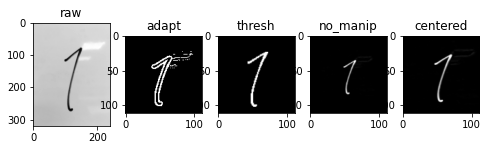

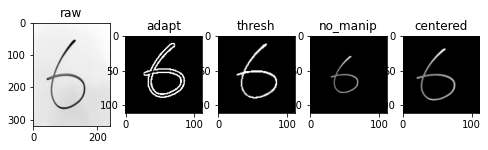

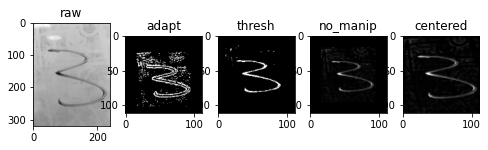

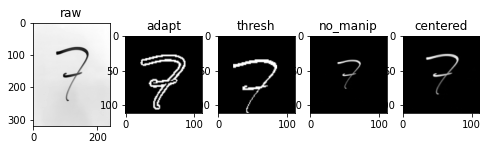

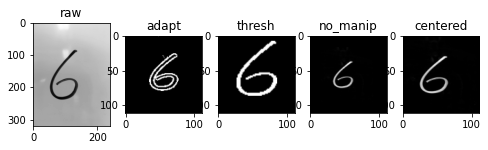

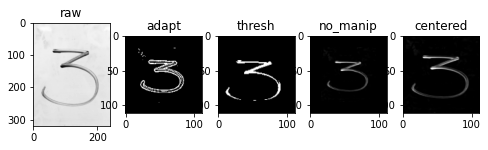

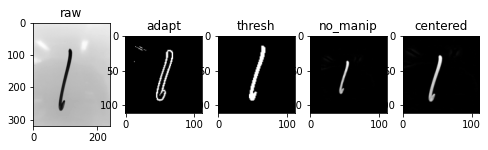

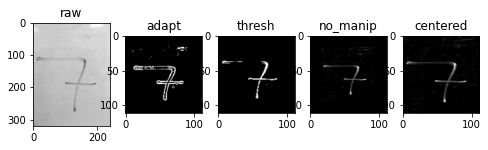

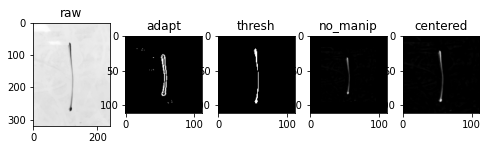

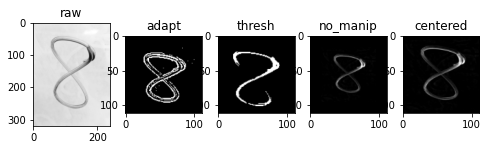

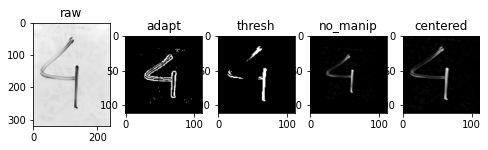

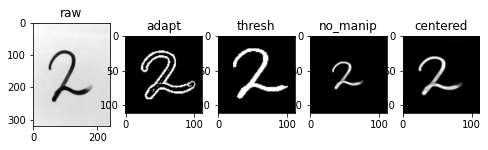

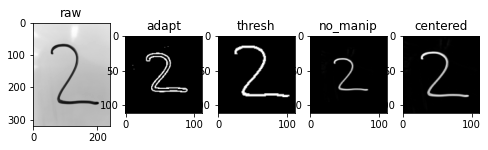

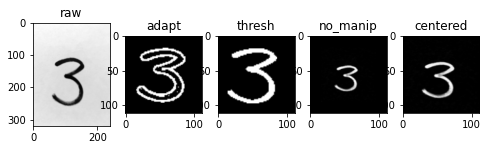

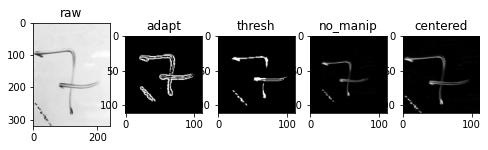

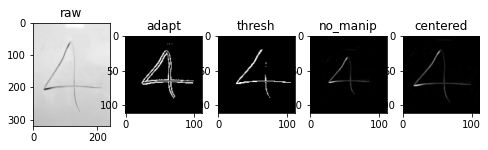

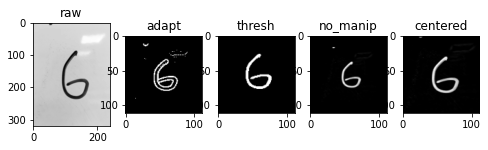

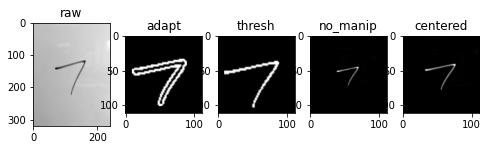

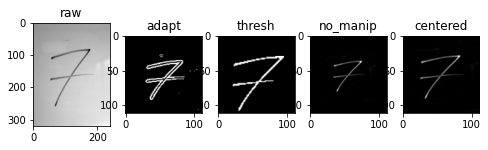

In [86]:
count = 0
for filename in os.listdir("/content/digits/digits"):
  if filename.endswith((".DS_Store")):
    pass
  elif count < 19:
    #adapt, good for faint digits but bad for messy background.
    #nonadaptive thresholding, good for messy background but strong digit
    img = cv2.imread("/content/digits/digits/" + filename, 0)
    #predict_chosen(img)
    compare_chosen(img)
    count += 1
  else:
    break